### Set up first DeepESN model

**Outline**

Use customized implementation of ESN layer with customized functions from **ESN_functions_v02.py** for setting up ESN model, training model and getting predictions with evaluation metrics.

* Apply **additive decomposition** of timeseries into linear trend, seasonality and residual noise, as in [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper "Time series prediction using Deep Echo State Networks", we are soon ready to switch from base ESN to Deep ESN models.
* Work with **stock index** values (S&P 500).

#### Technical setup: Import libraries and customized own functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v02 import *

In [2]:
# Read dataset SP500_1999_2019.txt, absolute values:
SP500_abs = open("../data/SP500_1999_2019.csv").read().split()
SP500_abs = np.array(SP500_abs).astype('float64')

#### Declare global (hyper-)parameters upfront

In [26]:
## Verbosity
verbose = True

## Decomposing timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
train_val_split = 0.8 # Specify the amount of samples used for training, the rest is used as validation data.
alpha = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
gamma = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
s = 126 # Choose cycle length for season S.
scaled_YN = True # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

## ESN model
n_layers = 3 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.5 # Leak rate used in transition function of reservoir states.
spec_radius = 1.0 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 4 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

#### Prepare input data

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  676.53
train_max:  2130.82


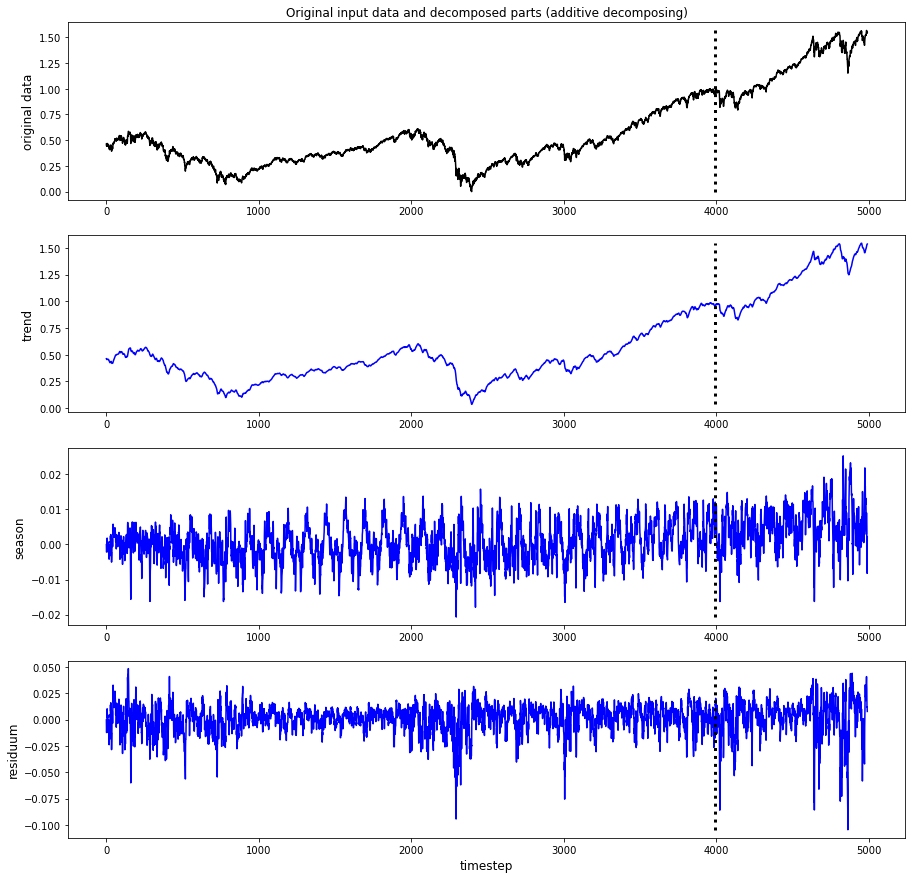


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.063965
p-value: 0.994897

Season S:
ADF Statistic: -9.959887
p-value: 0.000000

Residuum R:
ADF Statistic: -13.925091
p-value: 0.000000


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [27]:
# Scale, decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=scaled_YN,
                                                                                         verbose=verbose)

In [28]:
## Define function setESN to set up ESN model.
#
## Input parameters:
# input_length (int): Specified number of timesteps per input sample.
# n_features: Number of input features, e.g. original series plus decomposed parts L, S and R --> 4
# n_layers (int): Number of ESN layers in the model.
# n_res (int): Number of reservoir units.
# W_in_lim: Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
# leak_rate: Leak rate used in transition function of reservoir states.
# spec_radius: Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
# sparsity: Sparsity of reservoir weight matrix.
#
## Function output:
# Returns complete model "model".
# Returns short model "model_short" without output layer, for getting reservoir states for given inputs.

def setESN(input_length, n_features, n_layers, n_res, W_in_lim, leak_rate, spec_radius, sparsity, verbose=False):
    
    ## Set up model
    
    # Input layer
    model_inputs = Input(shape=(input_length, n_features)) # (timesteps, features)
    
    # Loop for setting up desired number of ESN layers:
    for l in range(n_layers):
        
        # First ESN needs to be connected to model_inputs:
        if l == 0:
            
            # Use custom layer for setting up reservoir, returns ALL reservoir states X and FINAL reservoir states X_T.
            X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate)(model_inputs)
            
            # Initialize storage for ALL final reservoir state tensors from ALL layers:
            all_X_T = X_T
            
        # Further ESN layers need to be connected to previous ESN layer:
        else:
            
            # Use new custom layer for setting up reservoir, again returns ALL reservoir states X and 
            # FINAL reservoir states X_T.
            X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate)(X)
            
            # Concatenate this layers final reservoir states with previous layers' final reservoir states
            all_X_T = tf.concat([all_X_T, X_T], axis=-1) 

    # Output unit
    output = Dense(units=1, activation=None, use_bias=True, 
                   kernel_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
                   bias_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
                   name='output')(all_X_T)

    # Define complete model "model" plus short model "model_short" omitting the output layer, 
    # for getting reservoir states for given inputs.
    model = Model(model_inputs, output, name='model')
    model_short = Model(model_inputs, all_X_T, name='model_short')
    
    
    ## Modify reservoir weights W_res using spectral radius:

    # Get model weights for ALL layers
    model_weights = np.array(model.get_weights())

    # Loop over desired number of ESN layers for reservoir weights:
    for l in range(n_layers):

        # First ESN needs special treatment for extracting weights, since we don't have concat-layer yet.
        if l == 0:

            # Extract reservoir weights
            W_res = model_weights[2]

        # Further ESN layers follow regular pattern in model weights:
        else:

            # Extract reservoir weights
            W_res = model_weights[l * 4]

        # Need temporary matrix W_temp to implement sparsity manually
        W_temp = np.random.uniform(low=0, high=1, size=(n_res,n_res))
        W_sparse = W_temp <= sparsity

        # Now apply sparsity to initial W_res
        W = W_sparse * W_res

        # Get largest Eigenvalue of W
        ev_max = np.max(np.real(np.linalg.eigvals(W)))

        # Finally set up W_res
        W_res = spec_radius * W / ev_max

        # Integrate modified reservoir weights back into model weights
        # First ESN again needs special treatment, since we don't have concat-layer yet.
        if l == 0:

            # Replace old weights by modified weights
            model_weights[2] = W_res

        # Further ESN layers follow regular pattern in model weights:
        else:

            # Extract reservoir weights
            model_weights[l * 4] = W_res

    # Get modified reservoir weights for all ESN layers back into the model
    model.set_weights(model_weights)

    
    # Optionally reveal model summaries proof of sparsity and max. Eigenvalues for reservoir weights
    if verbose:
        
        # Print model summaries
        model.summary()
        model_short.summary()  
        
        # Check sparsity and max Eigenvalues for ALL ESN layers' reservoir weights:
        # Get model weights for ALL layers
        model_weights = np.array(model.get_weights())

        # Loop over layers:
        for l in range(n_layers):
            if l == 0:
                W_res = model_weights[2]
            else:
                W_res = model_weights[l * 4]

            print("\nLayer ", l+1)
            print("========")
            print("W_res sparsity: ", sum(sum(W_res != 0)) / (W_res.shape[0]**2))
            print("W_res max EV: ", np.max(np.real((np.linalg.eigvals(W_res)))))

    # Return model
    return model, model_short

In [29]:
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
esn_3 (ESN)                     ((None, 10, 100), (N 10600       input_3[0][0]                    
__________________________________________________________________________________________________
esn_4 (ESN)                     ((None, 10, 100), (N 20200       esn_3[0][0]                      
__________________________________________________________________________________________________
tf.concat_1 (TFOpLambda)        (None, 200)          0           esn_3[0][1]                      
                                                                 esn_4[0][1]                  

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_2513/401357176.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_2513/401357176.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


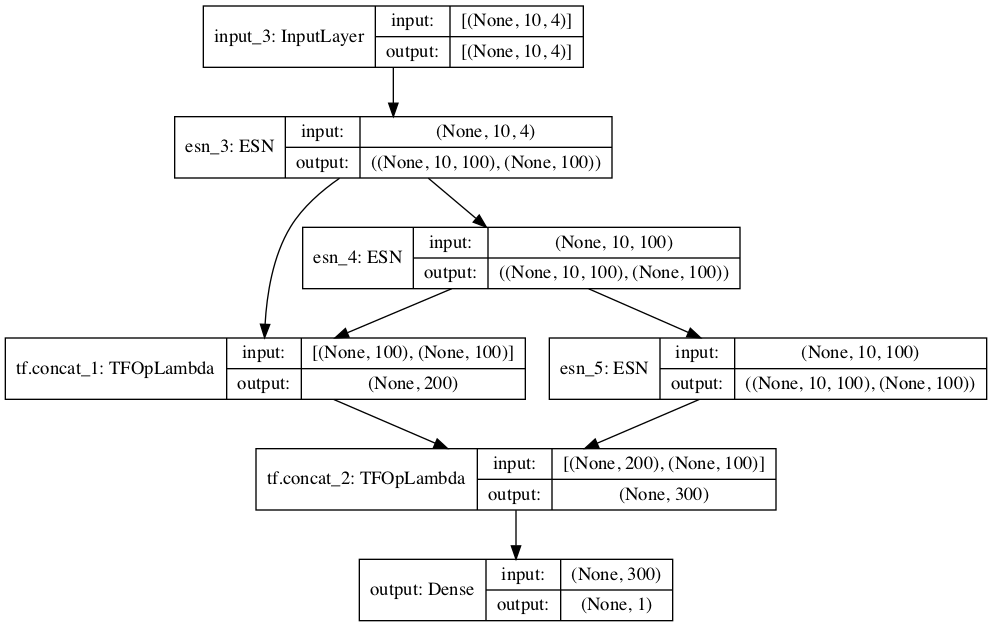

In [30]:
# Plot complete model
plot_model(model, show_shapes=True, show_layer_names=True)

### Solve for output weights with linear regression, without "augmented" notation

Our attempt to use "augmented" notation and include output bias $b_{out}$ as additional column in final reservoir states $X(T)$ failed. Inverting $X(T)$ drives bias to huge values and leads to poor prediction performance. So let's try another approach now. Remember:

Short model yields final reservoir states $X(T)$ with dimension (#samples, #reservoir units). We then have outputs weights $W_{out}$ with shape (#reservoir units, 1) and output bias $b_{out}$ as single value. Train targets $Y$ have dimension (#samples, 1).

The relation between final reservoir states, output weights and bias and train targets $Y$ reads:

$$X(T) \cdot W_{out} + \overline{b}_{out} = Y$$

Note: Here $\overline{b}_{out}$ denotes a vector of shape (#samples, 1), containing only the single output bias value $b_{out}$.

Instead of switching to "augmented" notation - we re-arrange the equation to obtain:

$$X(T) \cdot W_{out} = Y - \overline{b}_{out}$$

Solving for $W_{out}$ we need to invert $X(T)$, or get the pseudo-inverse $X_{inv}$, since $X(T)$ is usually not a square matrix:

$$W_{out} = X_{inv} \cdot (Y - \overline{b}_{out})$$

In [31]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)


shape of train input (samples, timesteps, features):  (3992, 10, 4)
shape of model output X_T (samples, n_res):  (3992, 300)


In [32]:
# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
#print("\nb_out: \n", b_out)


W_out shape:  (300, 1)
b_out shape:  (1,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_2513/2314246718.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


In [33]:
# Create vector of shape (samples, 1) containing only the single constant output bias as values.
b_out_vec = np.ones((X_T_train.shape[0], 1)) * b_out
print("\nb_out_vec shape: ",  b_out_vec.shape)


b_out_vec shape:  (3992, 1)


In [34]:
# Then need pseudo-inverse of final reservoir states
X_inv = np.linalg.pinv(X_T_train)

# Then get output weights
W_out = np.matmul(X_inv, train_target - b_out_vec)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out shape: ", W_out.shape)

train_input shape:  (3992, 10, 4)
train_target shape:  (3992, 1)
W_out shape:  (300, 1)


In [35]:
# Integrate trained output weights into model weights.
# Note: output layer is the LAST layer of the model, find weights at position "-2" of model_weights.
model_weights[-2] = W_out
model.set_weights(model_weights)


shape of val input (samples, timesteps, features):  (998, 10, 4)
shape of train input (samples, timesteps, features):  (3992, 10, 4)

shape of model predictions on validation input (samples, 1):  (998, 1)
shape of val targets (samples, 1):  (998, 1)

val_mae:  32.4799
train_mae:  0.0969


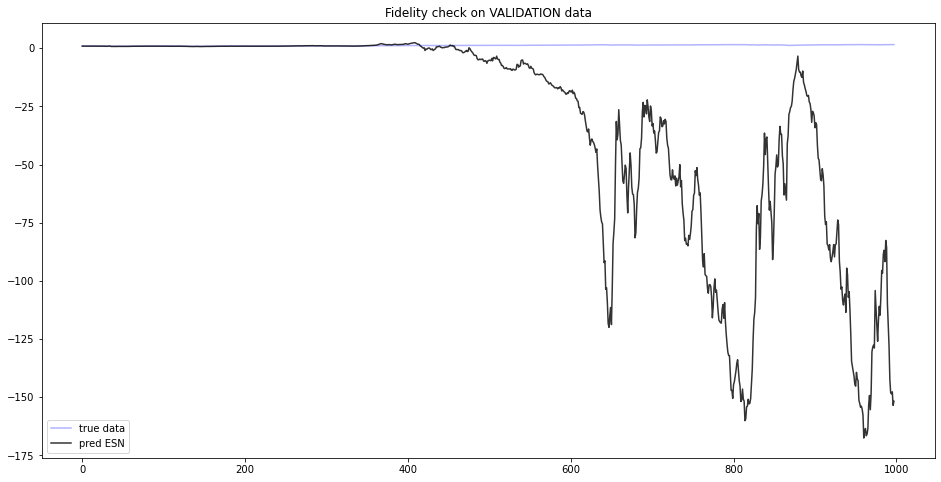

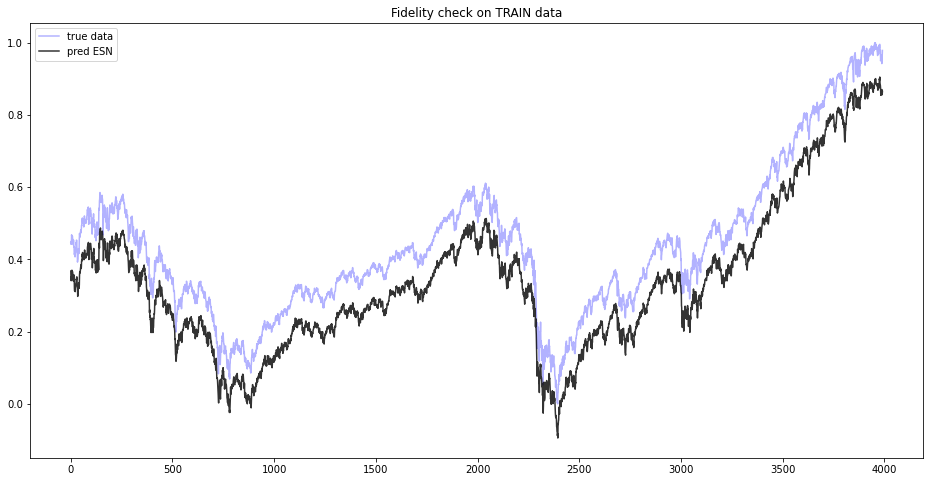

In [36]:
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()